<h3><b>Name:</b> Mosab Mohamed</h3>
<h3><b>Email:</b> o.mohamed@innopolis.university</h3>


---
---
---

<h3>Importing:</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

%matplotlib inline

<h3>Data Loading:</h3>

In [2]:
#Load the dataset
df = pd.read_csv('a1_dataset.csv')

#Drop var7 column
df = df.drop('var7',axis=1)

#Print some information about the dataset
print(df.shape)
print(df.head())
print(df.describe())

(925, 7)
   target    var1     var2          var3   var4    var5 var6
0       0  509.18  417.681    Micronesia  138.0  393.00   no
1       0  446.06  666.182      Dominica   81.0  352.05  yes
2       1  235.50  398.097   Isle of Man   90.0  339.00   no
3       0  306.02  518.163  Turkmenistan  102.0  439.25  yes
4       0  453.08  600.156      Cameroon  105.0  422.95   no
           target        var1        var2        var4        var5
count  925.000000  925.000000  925.000000  325.000000  925.000000
mean     0.496216  360.116562  548.390134  108.452308  325.393946
std      0.500256   87.866662  135.221460   26.325744   78.862779
min      0.000000  209.560000  139.965000   57.000000  163.000000
25%      0.000000  278.640000  467.373000   87.000000  257.900000
50%      0.000000  367.640000  569.841000  105.000000  342.350000
75%      1.000000  437.600000  652.278000  126.000000  393.000000
max      1.000000  539.920000  794.848000  180.000000  457.150000


<h3>Visualization:</h3>

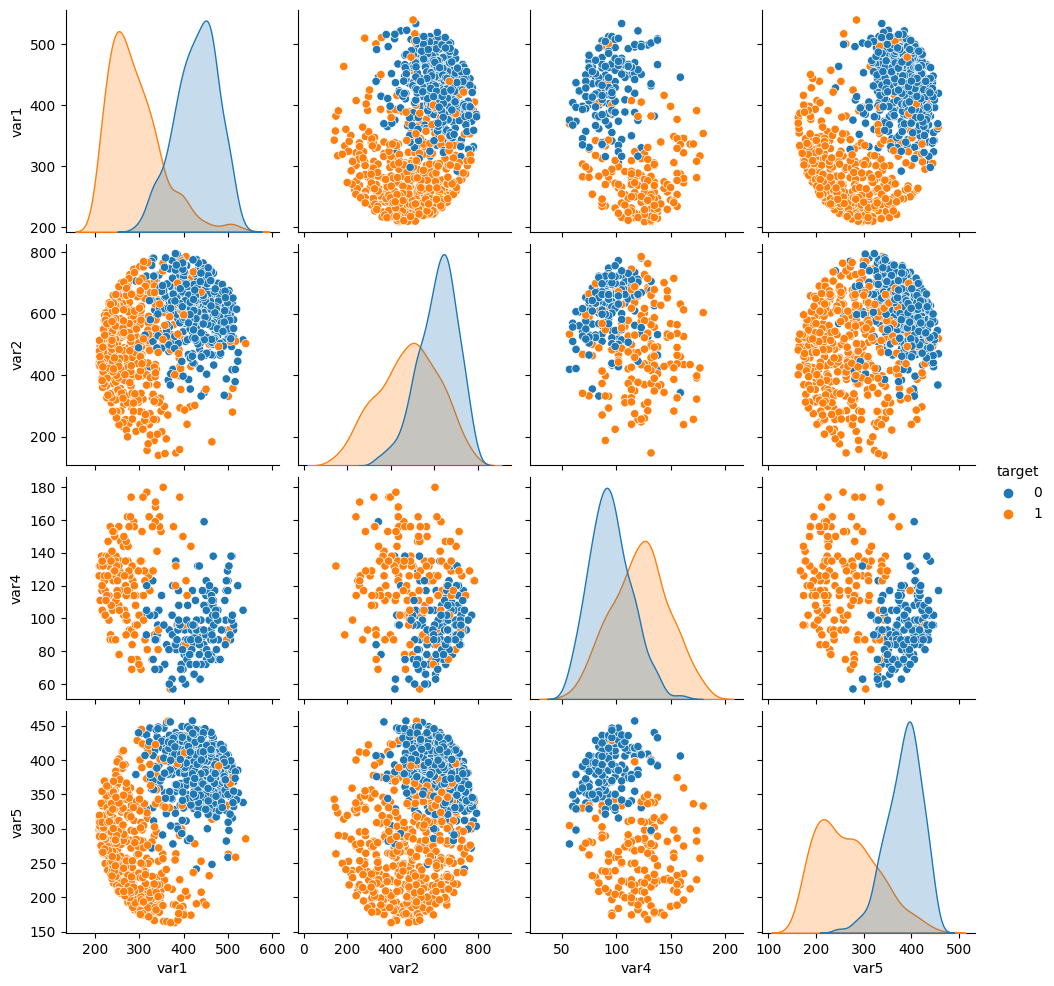

In [3]:
#Plot pairwise relationships
sb.pairplot(df, hue='target')

---
---
---

<h1>1.1 Preprocessing</h1>

---

<h3>Encoding categorical values</h3>
<p><b>Task:</b> Encode var3 and var6 columns</p>
<p><b>Solution:</b> I chose to encode these two columns using One Hot Encoding</p>
<p><b>Reasons:</b></p>
<p><b>1.</b> var3 consists of countries, which by definition has no ordinal relationship between eachother</p>
<p><b>2.</b> var6 consists of yes and no values, which when encoded using onehotencoding it will become 2 columns but then will be reduced to one column so it will be the same as using ordinal encoding</p>

---




In [4]:
#Reference: Lab3

#Function that transforms the dataframe and updates it with the encoded data.
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names_out(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first') #encoder model imported from sklearn
f_names = ['var3', 'var6'] #columns that will be encoded
encoder.fit(df[f_names]) #teach the model 
df = ohe_new_features(df, f_names, encoder) #get the new dataframe with encoded features 

---

<h3>Data imputation</h3>
<p><b>Task:</b> Implement a regression technique to find the missing values for var4</p>
<p><b>Solution:</b></p>
<p><b>1.</b> Split the dataset into 2 parts, the first part consists of the rows that have a valid var4 value, the second part consists of the rows that don't have a valid var4 value</p>
<p><b>2.</b> Take the part that has valid var4 values and split it into training and testing sets, where the training set will include only the columns that have relatively high correlation to var4 and testing set will be var4</p>
<p><b>3.</b> Scale the data by fitting and transforming on the training set and only transforming the testing set</p>
<p><b>4.</b> Try Linear and Polynomial regression to see which performs better using MSE</p>
<p><b>5.</b> After deciding on the type of regression, let the model predict the second part of the whole dataset that consists of non-valid var4 values</p>
<p><b>6.</b> After getting the values for all var4 merge the new column of var4 with the original dataframe to have a fully valid dataframe that we can use for the rest of the tasks</p>

---

1. Split dataset into 2 parts

In [5]:
#Split to valid var4 and non-valid var4 sets
var4_df = df[~df['var4'].isnull()]
var4_nan_df = df[df['var4'].isnull()]

2. Find high correlation columns and split the valid var4 set to training and testing sets accordingly

In [6]:
#get the columns with high correlation with var4
df_corr = var4_df.corr()['var4'].abs().sort_values(ascending=False)
cols = df_corr[df_corr > 0.2].index.to_list()[1:]

#Split the valid var4 part to training and testing sets
X = var4_df[cols]
y = var4_df.var4.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Scale the data

In [7]:
#Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4. Try linear and polynomial regression 

In [8]:
#Function to print Errors
def print_metrics_error(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [9]:
#Linear Regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print_metrics_error(y_test,y_pred)

Mean Absolute Error: 18.553412219044727
Mean Squared Error: 579.2025699555186
Root Mean Squared Error: 24.066627722959414


In [10]:
#Function to produce a pipeline for a polynomial regression with a specific degree
def polynomial_regression(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                        ("linear_regression", linear_regression)])
    pipeline.fit(X_train,y_train)
    return pipeline

In [11]:
#Polynomial regressions with 3 different degrees:[2,3,4] to see which degree is best
for i in [2,3,4]:
    pipeline = polynomial_regression(degree=i)
    y_pred_poly = pipeline.predict(X_test)
    print(f"degree {i}:")
    print_metrics_error(y_test,y_pred_poly)


degree 2:
Mean Absolute Error: 17.2875
Mean Squared Error: 553.4703770564153
Root Mean Squared Error: 23.525951140313442
degree 3:
Mean Absolute Error: 14.384164663461538
Mean Squared Error: 438.9522550729605
Root Mean Squared Error: 20.951187438256586
degree 4:
Mean Absolute Error: 14.42734375
Mean Squared Error: 463.19708052415115
Root Mean Squared Error: 21.522013858469453


5. Pick the optimal regression, and predict the rest of var4

In [12]:
#Optimal regression
degree = 3 #degree with the best MSE
pipeline = polynomial_regression(degree)

In [13]:
#Predict rest of var4
X = var4_nan_df[cols]
X = scaler.transform(X)

poly_var4 = pipeline.predict(X)


6. Merge all of var4 with the rest of the dataset

In [14]:
#Merge to produce a valid dataframe
poly_var4 = np.append(y, poly_var4, 0)
poly_df = df.drop('var4', axis=1)
poly_var4 = pd.DataFrame(poly_var4, dtype=int, columns=['var4'])
poly_df = pd.concat([poly_df, poly_var4], axis=1)
df = poly_df
df

/tmp/ipykernel_307381/4240992704.py:4: FutureWarning: In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)
  poly_var4 = pd.DataFrame(poly_var4, dtype=int, columns=['var4'])


,target,var1,var2,var5,var3_Albania,var3_Algeria,var3_American Samoa,var3_Andorra,var3_Angola,var3_Anguilla,...,var3_Vanuatu,var3_Venezuela,var3_Vietnam,var3_Wallis and Futuna,var3_Western Sahara,var3_Yemen,var3_Zambia,var3_Zimbabwe,var6_yes,var4
0,0,509.18,417.681,393.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,138
1,0,446.06,666.182,352.05,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,81
2,1,235.50,398.097,339.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90
3,0,306.02,518.163,439.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,102
4,0,453.08,600.156,422.95,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0,422.34,547.259,350.45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,59
921,1,342.62,473.919,200.85,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,133
922,1,265.10,538.170,208.35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,120
923,0,397.12,622.386,433.45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,100


---

<h3>Implementing the PCA technique</h3>
<p><b>Task:</b> Implement the PCA technique for reducing dimensionality to visualize the data</p>
<p><b>Solution:</b></p>
<p>1. Feature standardization.</p>
<p>2. Obtain the covariance matrix computation.</p>
<p>3. Calculate the eigendecomposition of the covariance matrix.</p>
<p>4. Sort the eigenvectors from the highest eigenvalue to the lowest.</p>
<p>5. Select the number of principal components.</p>
<p>6. visualize the data.</p>


---

In [15]:
#Reference: https://www.askpython.com/python/examples/principal-component-analysis

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Feature standaradization by centering the data
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        # Obtain the covariance matrix computation
        cov = np.cov(X, rowvar=False)

        # Calculate the eigendecomposition of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Sort the eigenvectors from the highest eigenvalue to the lowest
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[:,idxs]

        # Select the number of principal components 
        self.components = eigenvectors[:,0 : self.n_components]

    def transform(self, X):
        # Project data
        X = X - self.mean
        return np.dot(self.components.transpose(), X.transpose()).transpose()


In [16]:
#Visualizing the Data
def plot(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  pca = PCA(n_components=2)
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  
  feature1 = X_train[:, 0]
  feature2 = X_train[:, 1]

  sb.scatterplot(x=feature1, y=feature2, hue=y_train)


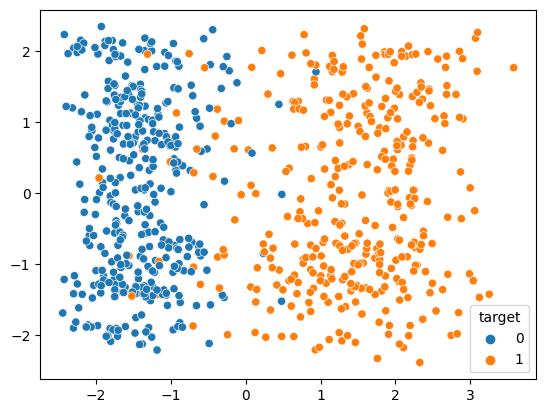

In [17]:
X = df.drop('target', axis=1)
y = df['target']
plot(X, y)

---
---

<h1>1.2 Training</h1>

---



In [18]:
#Function that prints the metrics for a given predictions
def print_metrics_APR(y_test,y_test_pred):
    print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
    print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
    print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

#Function that scales train and test sets 
def scale(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return (X_train, X_test)

#Function that applies PCA to train and test sets
def pca(X_train, X_test):
    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    return (X_train, X_test)

#Function that fits, cross validates and predicts the target for a given classification and returns the prediction and best hyper parameters
def classify(param_grid, clf):
    grid_search_clf = GridSearchCV(estimator=clf,
                            cv=3, scoring='accuracy',
                            param_grid=param_grid)
    grid_search_clf.fit(X_train, y_train)
    y_test_pred = grid_search_clf.predict(X_test)
    return (y_test_pred, grid_search_clf.best_params_)

#Reference: Lab5
#Function to display the correlation in a dataset
def display_correlation(df):
    corr_matrix = df.corr(method="spearman")
    plt.figure(figsize=(9,6))
    heatmap = sb.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Features Correlation")
    return(corr_matrix)

#Reference: Lab5
#Function that calculates VIF for a list of features to check for multicollinearity
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        tolerance[feature] = 1 - r2
        vif[feature] = 1/(tolerance[feature])
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

#Note: 
#Please understand that functions: display_correlation and calculate_vif were not copy-pasted with no thoughts involved
#these two functions were explained in the labs and it is how i understand the correlation and vif calculations 
#every part of these functions is important for this assignment later on, so there is nothing to change in them
#and i believe that i would be insulting the instructors if i change only the names and sizes just to try not to look like the original.
#Thank you for understanding.

target                      1.000000
var1                        0.784098
var5                        0.747803
var4                        0.599003
var2                        0.495492
                              ...   
var3_Gambia                 0.000352
var3_Suriname               0.000352
var3_Saint Lucia            0.000352
var3_Trinidad and Tobago    0.000352
var3_Portugal               0.000352
Name: target, Length: 241, dtype: float64


,var1,var5,var4,var2,target
var1,1.000000,0.515130,-0.496037,0.348298,-0.774589
var5,0.515130,1.000000,-0.409235,0.302379,-0.743450
var4,-0.496037,-0.409235,1.000000,-0.314161,0.650951
var2,0.348298,0.302379,-0.314161,1.000000,-0.489298
target,-0.774589,-0.743450,0.650951,-0.489298,1.000000


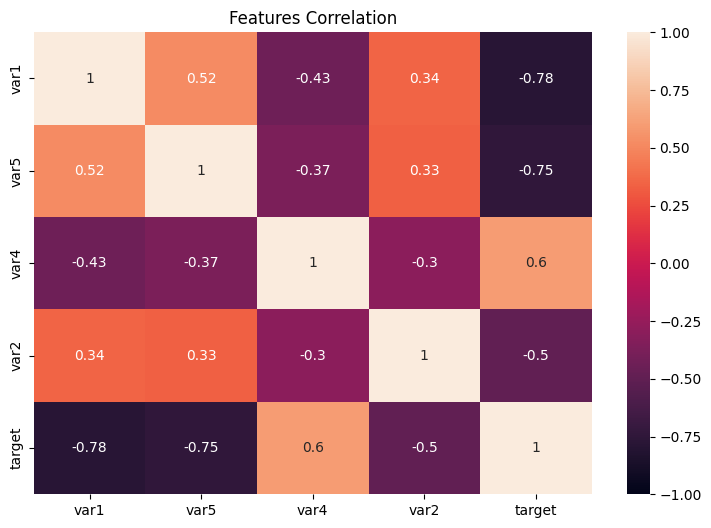

In [19]:
#Reference: Lab5
#feature selection preprocessing  
#we pick the features most correlated to the target
df_corr = poly_df.corr()['target'].abs().sort_values(ascending=False)
print(df_corr)
features = df_corr[df_corr > 0.4].index.to_list()[1:]
features_display = list(features)
features_display.append('target')
display_correlation(df[features_display])


In [20]:
#Check for multicollinearity in the list of features we have chosen
calculate_vif(df,df.columns).sort_values('VIF')

,VIF,Tolerance
var3_Lesotho,1.169511,0.855058
var3_Bermuda,1.170317,0.854469
var3_Montserrat,1.174740,0.851252
var3_Mozambique,1.176808,0.849756
var3_Aruba,1.177122,0.849530
...,...,...
var3_South Africa,2.354722,0.424679
var3_Czech Republic,2.538788,0.393889
var5,3.179952,0.314470
var1,3.745949,0.266955


Since we have no variable with VIF greater than 4 and no Tolerance smaller than 0.25, we can safely assume that there's no multicollinearity

Reference: https://corporatefinanceinstitute.com/resources/knowledge/other/variance-inflation-factor-vif/

---

<h3>Logistic Regression</h3>
<p><b>Task:</b> Implement Logistic Regression</p>
<p><b>Solution:</b></p>
<p>1. Split the dataset</p>
<p>2. scale the train and test sets</p>
<p>3. initialize the param grid with the hyperparameters</p>
<p>4. initialize the Logistic Regression classifier</p>
<p>5. fit and cross validate the data using GridSearchCV</p>
<p>6. predict the target and display the metrics and best hyper parameters</p>


---

In [21]:
#Logistic Regression
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [100, 500, 1000, 2000]
}
clf = LogisticRegression()

y_test_pred, best_params = classify(param_grid, clf)

print_metrics_APR(y_test, y_test_pred)
print(best_params)


Testing accuracy = 0.972972972972973
Testing precision = 0.9662921348314607
Testing recall = 0.9772727272727273
{'C': 100, 'max_iter': 100}


---

<h3>KNN</h3>
<p><b>Task:</b> Implement KNN</p>
<p><b>Solution:</b></p>
<p>1. Split the dataset</p>
<p>2. scale the train and test sets</p>
<p>3. initialize the param grid with the hyperparameters</p>
<p>4. initialize the KNN classifier</p>
<p>5. fit and cross validate the data using GridSearchCV</p>
<p>6. predict the target and display the metrics and best hyper parameters</p>



---

In [22]:
#KNN
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

param_grid = {'n_neighbors':list(range(1, 11)),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'cosine']
              }
clf = KNeighborsClassifier()

y_test_pred, best_params = classify(param_grid, clf)

print_metrics_APR(y_test, y_test_pred)
print(best_params)


Testing accuracy = 0.9837837837837838
Testing precision = 1.0
Testing recall = 0.9659090909090909
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


---

<h3>Naive Bayes</h3>
<p><b>Task:</b> Implement Naive Bayes</p>
<p><b>Solution:</b></p>
<p>1. Split the dataset</p>
<p>2. scale the train and test sets</p>
<p>3. initialize the param grid with the hyperparameters</p>
<p>4. initialize the Naive Bayes classifier</p>
<p>5. fit and cross validate the data using GridSearchCV</p>
<p>6. predict the target and display the metrics and best hyper parameters</p>


---

In [23]:
#Naive Bayes
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GaussianNB()

y_test_pred, best_params = classify(param_grid, clf)

print_metrics_APR(y_test, y_test_pred)
print(best_params)


Testing accuracy = 0.972972972972973
Testing precision = 0.9770114942528736
Testing recall = 0.9659090909090909
{'var_smoothing': 0.1}


---

<h3>Logistic Regression with PCA</h3>
<p><b>Task:</b> Implement Logistic Regression and apply PCA to it</p>
<p><b>Solution:</b></p>
<p>1. Split the dataset</p>
<p>2. scale the train and test sets</p>
<p>3. apply PCA</p>
<p>4. initialize the param grid with the hyperparameters</p>
<p>5. initialize the Logistic Regression classifier</p>
<p>6. fit and cross validate the data using GridSearchCV</p>
<p>7. predict the target and display the metrics and best hyper parameters</p>


---

In [24]:
#Logistic Regression with PCA
X = poly_df.drop('target', axis=1)
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

X_train, X_test = pca(X_train, X_test)

param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [100, 500, 1000, 2000]
}
clf = LogisticRegression()

y_test_pred, best_params = classify(param_grid, clf)

print_metrics_APR(y_test, y_test_pred)
print(best_params)


Testing accuracy = 0.9243243243243243
Testing precision = 0.9204545454545454
Testing recall = 0.9204545454545454
{'C': 0.1, 'max_iter': 100}


---

<h3>KNN with PCA</h3>
<p><b>Task:</b> Implement KNN and apply PCA to it</p>
<p><b>Solution:</b></p>
<p>1. Split the dataset</p>
<p>2. scale the train and test sets</p>
<p>3. apply PCA</p>
<p>4. initialize the param grid with the hyperparameters</p>
<p>5. initialize the KNN classifier</p>
<p>6. fit and cross validate the data using GridSearchCV</p>
<p>7. predict the target and display the metrics and best hyper parameters</p>


---

In [25]:
#KNN with PCA
X = poly_df.drop('target', axis=1)
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

X_train, X_test = pca(X_train, X_test)

param_grid = {'n_neighbors':list(range(1, 11)),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'cosine']
              }
clf = KNeighborsClassifier()

y_test_pred, best_params = classify(param_grid, clf)

print_metrics_APR(y_test, y_test_pred)
print(best_params)


Testing accuracy = 0.9027027027027027
Testing precision = 0.8645833333333334
Testing recall = 0.9431818181818182
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


---

<h3>Naive Bayes with PCA</h3>
<p><b>Task:</b> Implement Naive Bayes and apply PCA to it</p>
<p><b>Solution:</b></p>
<p>1. Split the dataset</p>
<p>2. scale the train and test sets</p>
<p>3. apply PCA</p>
<p>4. initialize the param grid with the hyperparameters</p>
<p>5. initialize the Naive Bayes classifier</p>
<p>6. fit and cross validate the data using GridSearchCV</p>
<p>7. predict the target and display the metrics and best hyper parameters</p>


---

In [26]:
#Naive Bayes with PCA
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = pca(X_train, X_test)

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GaussianNB()

y_test_pred, best_params = classify(param_grid, clf)

print_metrics_APR(y_test, y_test_pred)
print(best_params)

Testing accuracy = 0.9567567567567568
Testing precision = 0.9651162790697675
Testing recall = 0.9431818181818182
{'var_smoothing': 0.0533669923120631}
